# Analysis with Random Forest class 1st shot
### Thorowing in all potentials imports - including the kitchen sink (needs clean up)

In [1]:
import os
import pandas as pd
from tqdm import tqdm

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

from load_data import load_parse_save
from hlp_analysis import (resample_split_data, print_prediction_results, fstat)

### Load data & mark any prior & fail metrics as Failed set 

In [2]:
# Load Data from csv file & process via load_parse_save
pkl_file = './parsed_dataframe.pkl'
if os.path.isfile(pkl_file):
    # Alternative is Load from Pickled set: Saves Time
    prev_df = pd.read_pickle(pkl_file)
else:
    tqdm.pandas(desc='load & parse csv')
    prev_df = load_parse_save(save_file='./parsed_dataframe.pkl', debug=True)

### Add column Fail_set & mark it
This is a bit too close for comfort.
Ideally, we would cut off data at least 7 days prior to Failure if possible,
as one does NOT want to wait until last min.
#### So, this will be an improvement for later
Only the data prev to fail is one group & other group is no Failure + post Failure
#### N.B.: This only works because there is only ONE failure for each device.
Must deal with multiple Fails on a device with a bit more sophistication

In [16]:
prev_df['Fail_set'] = prev_df.daysDelta.apply(lambda x: True if x <= 0.0 else False)
# This is save to pickle file so it can be graphed
prev_df.to_pickle('./prev_df_saved.pkl')

# look at devices level & create group level Stat!
### Need to think of better stats The idea is that extreme values on the metrics are likely indicator of an issue

In [4]:
ggrp = prev_df.groupby(['device'])
groupd_prev_stat = ggrp.apply(fstat)

### Split the data into Train & Test, then use Random Forest to Predict
#### Not sure RF is a good model as results are volatile

In [5]:
X_train, X_test, y_train, y_test = resample_split_data(groupd_prev_stat, resample_ratio=.5, debug=True)

RF_clf = RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
RF_clf.fit(X_train, y_train)

y_pred = RF_clf.predict(X_test)

Distribution before imbalancing: Counter({False: 1063, True: 106})
Distribution after  imbalancing: Counter({True: 106, False: 53})


## Accuracy of the model
#### N.B. General Accuracy is extremely misleading as imbalance class issue comes up
Only 20% ~ 50% of True fails & F1_score 25% ~ 55% achieved w/o imbalance adj
This climbs to around 80~90+% with adj
#### This is business decision as some business cannot tolerate any fails/downtime like electronic manufacturing.
In this case nearly or all potential fails must be investigated even if few dozen UnFails creep in for every REAL Failures.

In [6]:
print("Random Forrest Model")
print_prediction_results(y_train, y_test, y_pred)

Random Forrest Model
Result from confusion_matrix
[[ 9  3]
 [ 4 32]]

Training data had 111 data points & 70 fails
Testing  data had 48 data points & 36 fails
Out of 36 Fails, predicted 32 or 88.9% correctly
Accuracy: 85.417%
*F1_score = 90.1%


# Boosted Models
For imbalanced data usual techniques are:
- Random over & under Resampling (Either can disregard useful data w/ undersample or overfit w/ oversample)
- Clustered over-sampling (outperfoms underampling & outperforms it, but often over fits)
- SMOT (Synthetic Minority Over-sampling Technique): Really difficult wiht hi-dim data
- Bagging: Only works if based classifiers distribution is not extreme
- Various Boosting (Ada, Gradient, & XG): Ada Sensitive, XG fast & less prone to issues

In [7]:
#X_train, X_test, y_train, y_test = resample_split_data(groupd_prev_stat, resample_ratio=.5, debug=True)

#boost_clf = AdaBoostClassifier( DecisionTreeClassifier(max_depth=1), n_estimators=200 )

boost_clf = XGBClassifier()

boost_clf.fit(X_train, y_train)
predictions = boost_clf.predict(X_test)

### *** Volatile F1 65-75% wo/ imbalance adj BUT climbs to 85-90% w/ adj ***
- The results are better F1 score & hit ratio, but still very data random selection dependent.
- Likely results of using max/min from the metrics + needs better agg_metrics/factors
- The confusion matrix seems to indicate that model is still dominated by dominant classifier.
- Indicating that results may be better with Either sampling or SMOT 
- So, reduced resample ratio to 1/2 of the minor classification, which is a bit extreme
- Ada or XG boost do about 3+/-% better on F1 score vs RF
- Highest F1 was about 98%, which is unusual but given small data not unusual

In [8]:
print("XGBoost Model")
print_prediction_results(y_train, y_test, predictions)

XGBoost Model
Result from confusion_matrix
[[ 9  3]
 [ 4 32]]

Training data had 111 data points & 70 fails
Testing  data had 48 data points & 36 fails
Out of 36 Fails, predicted 32 or 88.9% correctly
Accuracy: 85.417%
*F1_score = 90.1%


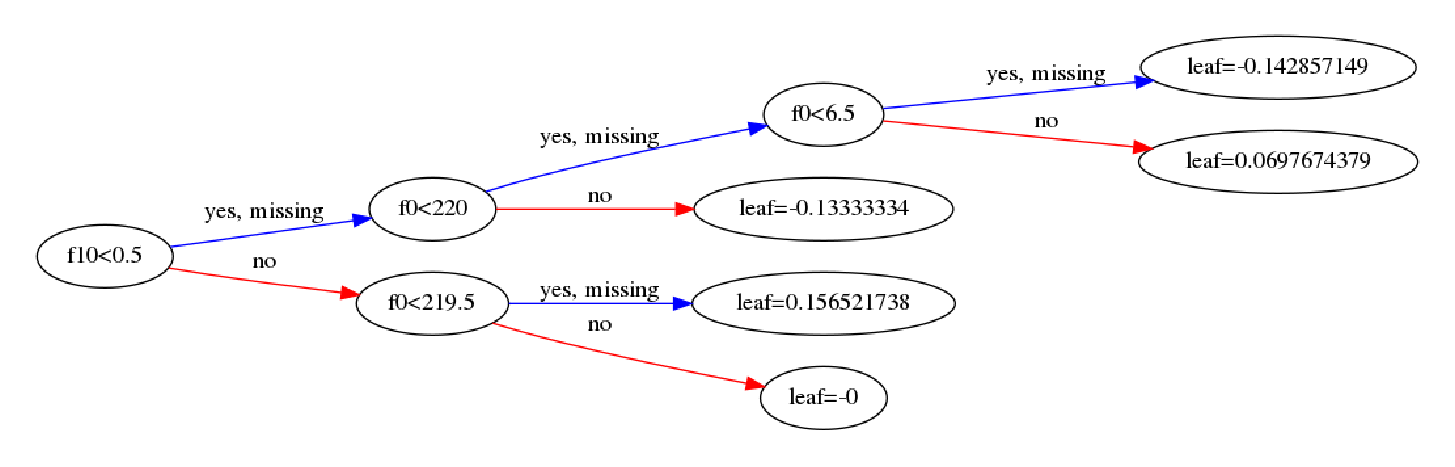

In [9]:
# plot decision tree
from xgboost import plot_tree
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

mpl.rcParams['figure.dpi'] = 300
#%config InlineBackend.figure_format = 'svg'

plot_tree(boost_clf, num_trees=0, rankdir='LR')
plt.show()

In [15]:
X_test.shape

(48, 28)